In [6]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import random
import matplotlib.pyplot as plt
# Function to generate a random date within a rangedef random date(start, end):return start + timedelta(days=random.randint(0, int((end - start).days))
# Define the start and end dates for the dataset periodstart date = datetime(2009, 1, 1)end date = datetime(2011, 12, 31)
# Sample values for categorical variablescustomer _country_codes = [USA CANGBR,AUSDEUTproduct codes = [P001, P002 P003 P004 P0057order types = [VOTroutes = [Air', "Sea Road' Rail7currencies = [USD'CAD GBPAUDEURT

In [7]:
# Function to generate a random date within a range
def random_date(start, end):
    return start + timedelta(
        days=random.randint(0, int((end - start).days)))

# Define the start and end dates for the dataset period
start_date = datetime(2009, 1, 1)
end_date = datetime(2011, 12, 31)

In [8]:
# Sample values for categorical variables
customer_country_codes = ['USA', 'CAN', 'GBR', 'AUS', 'DEU']
product_codes = ['P001', 'P002', 'P003', 'P004', 'P005']
order_types = ['VO']
routes = ['Air', 'Sea', 'Road', 'Rail']
currencies = ['USD', 'CAD', 'GBP', 'AUD', 'EUR']

In [9]:
# Number of rows in the dataset
num_rows = 2421

# Generating the dataset
data = []
for _ in range(num_rows):
    order_date = random_date(start_date, end_date)
    delivery_date = order_date + timedelta(days=random.randint(15,180))
    country_code = random.choice(customer_country_codes)
    product_code = random.choice(product_codes)
    order_type = random.choice(order_types)
    route = random.choice(routes)
    currency = random.choice(currencies)
    value = round(random.uniform(100, 1000), 2)
    items = random.uniform(100, 1000)
    description = f"Parka - {product_code}"

    data.append([order_date, delivery_date, country_code, product_code, description,
                 order_type, f'CO-{random.randint(1000, 9999)}', value, currency, items, route])

# Creating DataFrame
df = pd.DataFrame(data, columns=['Order Date', 'Requested Delivery Date', 'Customer Country Code',
                                 'Product Code', 'Description', 'Order Type', 'Customer Order Code',
                                 'Value', 'Currency', 'Items', 'Route'])

print(df.head())  # Display the first few rows of the dataset

  Order Date Requested Delivery Date Customer Country Code Product Code   
0 2011-09-27              2012-03-21                   CAN         P005  \
1 2011-12-18              2012-03-17                   AUS         P005   
2 2009-01-04              2009-06-13                   AUS         P004   
3 2010-10-16              2010-12-12                   AUS         P001   
4 2011-09-29              2011-10-25                   DEU         P003   

    Description Order Type Customer Order Code   Value Currency       Items   
0  Parka - P005         VO             CO-2527  299.73      CAD  929.999412  \
1  Parka - P005         VO             CO-2586  832.58      USD  172.526579   
2  Parka - P004         VO             CO-1096  391.07      AUD  138.449701   
3  Parka - P001         VO             CO-2746  492.77      USD  536.929248   
4  Parka - P003         VO             CO-3486  702.40      USD  699.578223   

  Route  
0  Rail  
1  Road  
2  Road  
3  Rail  
4  Rail  


In [10]:
# Next, let's calculate the average price of products ordered by each vendor (assuming 'Customer Country Code' as vendor identifier for simplicity).
# We will also create a simple predictive model for the next month's sales based on the average price.

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Calculate the average price of products ordered by each vendor
average_price_by_country = df.groupby('Customer Country Code')['Value'].mean().reset_index()
average_price_by_country.columns = ['Customer Country Code', 'Average Value']

# For a simple predictive model, we'll do the following steps:
# 2. Add a 'Month' column for the order date to aggregate monthly sales.
df['Order Month'] = df['Order Date'].dt.to_period('M')

# 3. Calculate the total sales value for each month.
monthly_sales = df.groupby('Order Month')['Value'].sum().reset_index()
monthly_sales['Order Month'] = monthly_sales['Order Month'].dt.to_timestamp()

# 4. We'll use the average monthly sales as a simple predictor for next month's sales.
# For this demonstration, we'll predict next month's sales based on past average.
# A more sophisticated model would use more features and possibly different modeling techniques.
monthly_sales['Next Month Sales'] = monthly_sales['Value'].shift(-1)

# Drop the last row since we don't have a sale value for the next month of the last row.
monthly_sales = monthly_sales.dropna()

# Let's prepare our features (X) and target (y) for the model.
X = monthly_sales[['Value']]  # Features (current month sales)
y = monthly_sales['Next Month Sales']  # Target (next month sales)

# Split the data into training and testing sets for model validation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model.
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set.
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE) for our predictions.
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Display the RMSE and the average price by country.
rmse, average_price_by_country

(3891.3447171849125,
   Customer Country Code  Average Value
 0                   AUS     528.883657
 1                   CAN     554.951543
 2                   DEU     557.582096
 3                   GBR     554.661106
 4                   USA     534.901391)

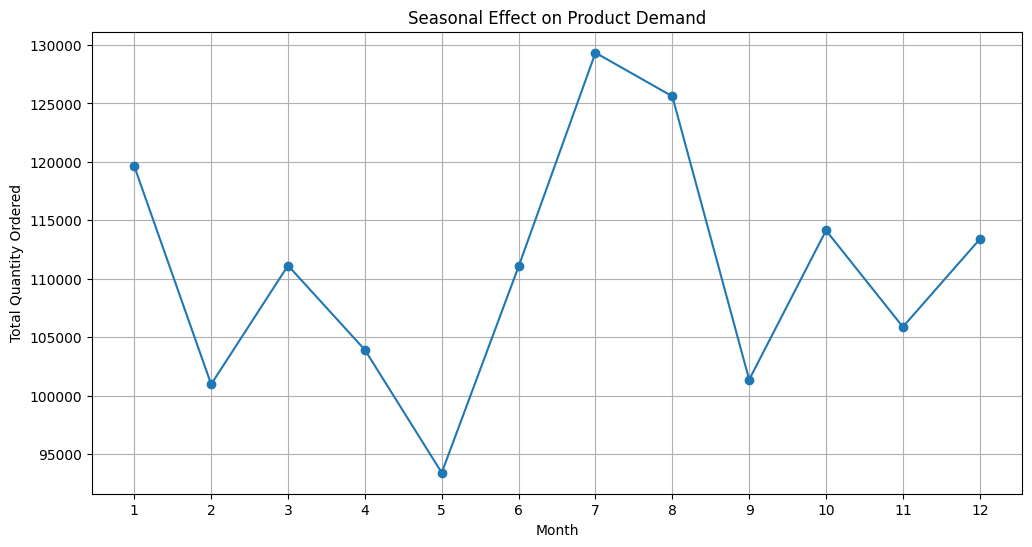

0.4824742268041237

In [11]:
# Let's continue with further analysis by analyzing the seasonality effect on the product demand.

# To analyze seasonality, we'll add a 'Month' column to the dataset to see how sales vary month over month.
df['Month'] = df['Order Date'].dt.month

# Group by month and sum the items to see the total quantity ordered each month.
seasonality = df.groupby('Month')['Items'].sum().reset_index()

# Let's also visualize this seasonality.
plt.figure(figsize=(12, 6))
plt.plot(seasonality['Month'], seasonality['Items'], marker='o')
plt.title('Seasonal Effect on Product Demand')
plt.xlabel('Month')
plt.ylabel('Total Quantity Ordered')
plt.grid(True)
plt.xticks(range(1, 13))  # Set x-ticks to be the months
plt.show()

# Determine the median number of items ordered.
median_items = df['Items'].median()

# Create a binary 'High Demand' column where 1 indicates demand is higher than the median.
df['High Demand'] = (df['Items'] > median_items).astype(int)

# For the logistic regression, we'll predict 'High Demand' based on the 'Value' and 'Month' as features.
# Prepare features and target variable for logistic regression.
X = df[['Value', 'Month']]
y = df['High Demand']

# Split the data into training and testing sets for model validation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform logistic regression.
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Predict on the test set and calculate the accuracy.
y_pred = logistic_model.predict(X_test)
accuracy = logistic_model.score(X_test, y_test)

# Display the accuracy of the logistic regression model.
accuracy

In [12]:
# To further enhance the demand forecasting, let's explore a few more steps:
# 1. Create additional features such as lagged values and moving averages that could help capture trends and seasonality more effectively.
# 2. Use these features in a more complex model, such as a Random Forest, to see if we can improve the predictive performance.

from sklearn.ensemble import RandomForestClassifier

# Add lagged sales values and moving averages as new features
df['Lagged_Value'] = df['Value'].shift(1).fillna(method='bfill') # Lagged by 1 period
df['Moving_Average_Value'] = df['Value'].rolling(window=3).mean().fillna(method='bfill') # 3-period moving average

# Update features for the model
X = df[['Value', 'Month', 'Lagged_Value', 'Moving_Average_Value']]
y = df['High Demand']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Predict on the test set and calculate accuracy
rf_accuracy = random_forest_model.score(X_test, y_test)

# Calculate feature importance to understand which features are driving the predictions
feature_importances = random_forest_model.feature_importances_

# Display the accuracy and feature importances of the Random Forest model
rf_accuracy, feature_importances

(0.4824742268041237, array([0.28864219, 0.13310062, 0.28979848, 0.2884587 ]))

In [13]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search for the best parameters for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Find the best parameters and the best model score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best estimator to predict on the test set
best_rf = grid_search.best_estimator_
best_rf_accuracy = best_rf.score(X_test, y_test)

# Display the best parameters, best score from cross-validation, and test set accuracy
best_params, best_score, best_rf_accuracy


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_dep

({'max_depth': 30,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 200},
 0.5325437396500828,
 0.4845360824742268)

In [14]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# We need to ensure our time series data is stationary before fitting an ARIMA model.
# Let's take the 'Value' column and use it to create a time series for modeling.

# First, we create a new DataFrame that holds the date as the index and the total sales as the value
time_series_data = df.set_index('Order Date')['Value'].resample('M').sum()

# Check for stationarity
stationarity_test = sm.tsa.adfuller(time_series_data, autolag='AIC')

# If the p-value is less than 0.05, we consider the series to be stationary.
# If not, we'll take the first difference of the series until it becomes stationary.
p_value = stationarity_test[1]

# Differencing until stationary
while p_value >= 0.05:
    time_series_data = time_series_data.diff().dropna()
    stationarity_test = sm.tsa.adfuller(time_series_data, autolag='AIC')
    p_value = stationarity_test[1]

# Now let's fit an ARIMA model. We'll use p=1, d=1, q=1 which are common starting parameters.
arima_model = ARIMA(time_series_data, order=(1, 1, 1))
arima_results = arima_model.fit()

# Summary of the model
arima_summary = arima_results.summary()

# Let's try to forecast the next 12 months.
forecast = arima_results.get_forecast(steps=12)
forecast_index = pd.date_range(time_series_data.index[-1] + pd.Timedelta(days=1), periods=12, freq='M')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({'Forecast': forecast_values}, index=forecast_index)

# Summary and forecasted values
arima_summary, forecast_df


(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                  Value   No. Observations:                   36
 Model:                 ARIMA(1, 1, 1)   Log Likelihood                -348.599
 Date:                Mon, 11 Dec 2023   AIC                            703.197
 Time:                        13:26:43   BIC                            707.863
 Sample:                    01-31-2009   HQIC                           704.808
                          - 12-31-2011                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          0.1924      0.183      1.051      0.293      -0.166       0.551
 ma.L1         -0.7867      0.148     -5.319      0.000      -1.077   